## KCF tracker test

### 1. Imports

In [111]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from helpers.limbus_detection import detect_circle
from helpers.misc import repair_bbox, tighten_circle
from helpers.view_detection import get_view_mask


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2. Naive test

In [112]:
kcf_params = cv2.TrackerKCF_Params()
# kcf_params.compressed_size = 1
# kcf_params.desc_pca = cv2.TrackerKCF_GRAY
# kcf_params.desc_npca = cv2.TrackerKCF_GRAY
# kcf_params.resize = True
# kcf_params.detect_thresh = 0.7


def reset_tracker(frame: np.array, view_mask: np.array = None) -> cv2.TrackerKCF:
    circle = detect_circle(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), validation='inout',
                           validation_value_thresh=40, view_mask=view_mask)
    if circle is None:
        return None

    tracker = cv2.TrackerKCF_create(kcf_params)

    bbox = (round(circle[0] - circle[2]), round(circle[1] - circle[2]),
            round(circle[2]*2), round(circle[2]*2))
    tracker.init(frame, bbox)

    return tracker

In [113]:
filepath = 'data/artificial/bioniko_input_long.mp4'
cap = cv2.VideoCapture(filepath)

_, frame = cap.read()
tracker = reset_tracker(frame)

while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        break

    timer = cv2.getTickCount()

    if tracker is None:
        ok = False
    else:
        ok, bbox = tracker.update(frame)

    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    if ok:
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.circle(frame, (round(bbox[0] + bbox[2]/2), round(bbox[1] + bbox[3]/2)),
                   round((bbox[2] + bbox[3])/4), (255, 0, 0))
        cv2.putText(frame, "width v. height diff: %d" % abs(bbox[2] - bbox[3]),
                    (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0, 0, 255) if abs(bbox[2] - bbox[3]) > 0 else (0, 255, 0), 2)
        cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)
    else:
        cv2.putText(frame, "Tracking failure detected", (100, 80),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        tracker = reset_tracker(frame)

    if fps < 20:
        tracker = None

    cv2.putText(frame, "FPS : " + str(int(fps)), (100, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50, 170, 50), 2)
    cv2.imshow("Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

### 3. KFC tracking with circle jiggle/tighten
OpenCV trackers usually output a 2D bounding box which can be not very tight. Because of this we need a corrective mechanism to detect the circle precisely.
`circle_tighten` method in contrast to `circle_jiggle` tries to also adjust for the radius.

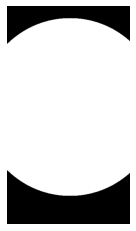

In [119]:
filepath = 'data/artificial/bioniko_input_long.mp4'
cap = cv2.VideoCapture(filepath)

_, frame = cap.read()
view_mask = get_view_mask(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
# tracker = reset_tracker(frame, view_mask=view_mask)
tracker = reset_tracker(frame)

plt.imshow(view_mask, cmap='gray')
plt.axis('off')
plt.show()

In [120]:
while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        break

    if tracker is None:
        ok = False
    else:
        ok, bbox = tracker.update(frame)

    if ok:
        new_bbox = repair_bbox(bbox, frame.shape[1], frame.shape[0])
        if new_bbox is not None:
            bbox = new_bbox
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        circle_tightened = tighten_circle(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),
                                          np.array((bbox[0] + bbox[2]/2,
                                                    bbox[1] + bbox[3]/2,
                                                    (bbox[2] + bbox[3])/4)),
                                          view_mask=view_mask)
        circle_jiggled = jiggle_circle(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),
                                       np.array((bbox[0] + bbox[2]/2,
                                                 bbox[1] + bbox[3]/2,
                                                 (bbox[2] + bbox[3])/4)),
                                       view_mask=view_mask)

        cv2.circle(frame, (round(circle_tightened[0]), round(
            circle_tightened[1])), round(circle_tightened[2]), (255, 0, 0), 1)
        cv2.circle(frame, (round(circle_jiggled[0]), round(
            circle_jiggled[1])), round(circle_jiggled[2]), (255, 255, 0), 1)
        cv2.putText(frame, 'width v. height diff: %d' % abs(bbox[2] - bbox[3]),
                    (0, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0, 0, 255) if abs(bbox[2] - bbox[3]) > 0 else (0, 255, 0))

        cv2.rectangle(frame, p1, p2, (0, 255, 0), 1, 1)
    else:
        cv2.putText(frame, 'Tracking failure detected', (0, 80),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255))
        tracker = reset_tracker(frame, view_mask=view_mask)

    if fps < 10:
        tracker = None

    cv2.putText(frame, 'KCF tracker', (0, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0))
    cv2.putText(frame, 'jiggle_circle', (0, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 0))
    cv2.putText(frame, 'tighten_circle', (0, 75),
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0))

    cv2.imshow('tracking', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

/Users/mirek/Documents/Custom_Surgical/Cataract-Surgery-Training-Explorations/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mirek/Documents/Custom_Surgical/Cataract-Surgery-Training-Explorations/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
